In [1]:
import pandas as pd
import os
import numpy as np
import random 
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/project_data/train_data.csv')
data = train_data.copy()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
feature_description = pd.read_excel('/content/drive/My Drive/Colab Notebooks/project_data/data_dictionary.xlsx')
feature_description

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
...,...,...
148,settlement_amount,The loan amount that the borrower has agreed t...
149,settlement_percentage,The settlement amount as a percentage of the p...
150,settlement_term,The number of months that the borrower will be...
151,NaN,NaN


In [4]:
label = data['loan_status']
data = data.drop(['loan_status'], axis = 1)

for i in range(len(label)):
    if label[i] == 'Charged Off':
        label[i] = 1
    else:
        label[i] = 0

import sklearn.model_selection as model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(data, label, train_size=0.7,test_size=0.3, random_state=101, stratify = label)

In [5]:
def data_preprocessing(data, miss_threshold, category):
    '''
    Data: dataframe type original data
    miss_threhold: float type, determine whether keep the feature
    category: boolean type, determine whether keep categoical data
    '''
    if category == False: 
        categorical = []
        for name in data.columns:
            for x in data[name][data[name].isna() == False]:
                if type(x) != str:
                    categorical.append(name)
                    break
        data = data[categorical]
                
    
    data = data[[x for x in data.columns if (sum(data[x].isna())/len(data)) <= miss_threshold]]
    unchanged_feature = [x for x in data.columns if len(data[x].unique()) == 1]
    data = data.drop(unchanged_feature, axis = 1)
    
    return data

In [6]:
miss_threshold = 0.25
category = False
X_train = data_preprocessing(X_train, miss_threshold, category)


In [7]:
def categorical_check(df, threshold):
    non_cate = []
    for x in df.columns:
        if len(df[x].unique()) >= threshold:
            non_cate.append(x)
            
    return df[non_cate]

In [8]:
threshold = 100
numerical = categorical_check(X_train, threshold)
numerical3 = numerical.drop(['recoveries', 'out_prncp', 'out_prncp_inv', 'collection_recovery_fee'], axis = 1)
numerical_test3 = X_test[numerical3.columns]

### Some Visualizaton

In [9]:
from scipy.cluster import hierarchy
def corr_ord(df):
  cov = np.cov(df, rowvar = False)
  order = np.array(hierarchy.dendrogram(hierarchy.ward(cov), no_plot = True)['ivl'], dtype= 'int')
  order_features = []
  for x in order:
    for i, name in enumerate(list(df.columns)):
      if x == i:
        order_features.append(name)
        break
  return df[order_features]

## Model



### Baseline Model

In [10]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=100, random_state=0)

y_train = np.array(y_train.astype(int))
y_test = np.array(y_test.astype(int))

mice_imp_x = imp.fit_transform(numerical3, y = y_train)
mice_imp_x_test = imp.fit(numerical3, y = y_train).transform(numerical_test3)

In [11]:
numerical3.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'revol_bal', 'revol_util',
       'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'last_pymnt_amnt',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mths_since_recent_bc', 'num_il_tl', 'num_rev_accts', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort',
       'total_bc_limit', 'total_il_high_credit_limit'],
      dtype='object')

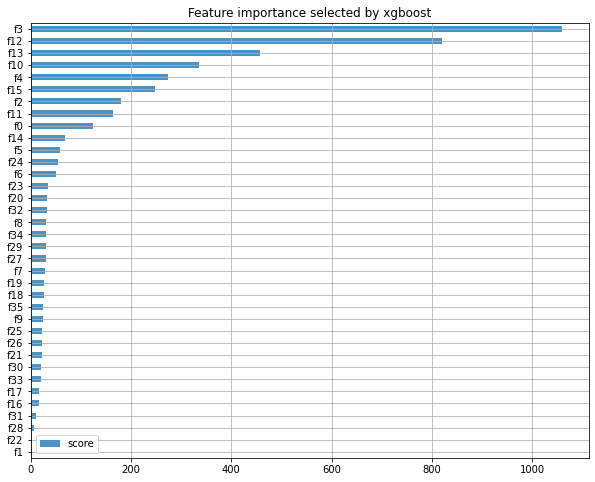

In [12]:
import xgboost as xgb
dtrain = xgb.DMatrix(mice_imp_x, y_train)
param = {'max_depth':4, 'objective':'binary:logistic', 'nthread': 8, 'eval_metric': 'auc' , 'learning_rate': 0.5, 'n_estimators': 50, 'n_jobs': -1 }

num_round = 300
bst = xgb.train(param, dtrain, num_round)

feature_important = bst.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

feature_importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
feature_importance.plot(kind='barh', grid=True, figsize = (10,8), alpha = 0.8, legend = True, title = 'Feature importance selected by xgboost')




In [13]:
selected_features = feature_importance.index[feature_importance.score > 50]


selected_features_index = [int(x[1:]) for x in selected_features]
features_names = list(numerical3.columns[selected_features_index])

selected_column_index = []
for x in features_names:
  for i in range(len(X_test.columns)):
    if X_test.columns[i] == x:
      selected_column_index.append(i)


selected_features = [int(x[1:]) for x in selected_features]
feature_x = mice_imp_x[:,selected_features]      



In [14]:
feature_x = mice_imp_x[:,selected_features]      

feature_x_test = mice_imp_x_test[:,selected_features]      


In [15]:
# from sklearn import preprocessing

# def stadardize(X):
#   scaler = preprocessing.StandardScaler().fit(X)
#   X = scaler.transform(X)
#   return X

In [16]:
# feature_x = stadardize(feature_x)

# feature_x_test = stadardize(feature_x_test)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# generate dataset

rf = RandomForestClassifier(max_depth = 5, min_samples_leaf = 3,  n_estimators = 100, class_weight = 'balanced', criterion = 'gini')


# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# evaluate model
scores = cross_val_score(rf, feature_x, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))


Mean ROC AUC: 0.865


In [18]:
from sklearn import metrics

rf = RandomForestClassifier(max_depth = 5, min_samples_leaf = 3,  n_estimators = 100, class_weight = 'balanced', n_jobs=-1, criterion = 'gini')
pred = rf.fit(feature_x, y_train).predict(feature_x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)

metrics.auc(fpr, tpr)

0.7862994748289677

In [19]:
from sklearn import metrics

rf = RandomForestClassifier(max_depth = 20, min_samples_leaf = 2,  n_estimators = 100, class_weight = 'balanced_subsample', n_jobs=-1, criterion = 'gini')
pred = rf.fit(feature_x, y_train).predict(feature_x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)

metrics.auc(fpr, tpr)

0.8791256214349688

In [20]:
a = rf.fit(feature_x, y_train).predict(feature_x)
fpr, tpr, thresholds = metrics.roc_curve(y_train, a)
metrics.auc(fpr, tpr)

0.944550691655379

### Tune the Hyperparameters



In [33]:
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 300, num = 2)]

max_depth = [10, 30, 40]
max_depth.append(None)


class_weight = ['balanced', 'balanced_subsample']
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'class_weight':class_weight
               }

rf = RandomForestClassifier()
pprint(random_grid)

cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state= 5)


{'class_weight': ['balanced', 'balanced_subsample'],
 'max_depth': [10, 30, 40, None],
 'n_estimators': [200, 300]}


In [34]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')

rf_random.fit(feature_x, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 129.3min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed: 263.2min finished


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=2, random_state=5),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples...
                     

In [ ]:
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/project_data/capstone_test_data_20200723.csv')

In [35]:
rf_random.best_params_

{'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 300}

In [36]:
rf_random.best_score_

0.9798201495327745

#### Use the best random forest hyperparameter and retrain the model

In [40]:
rf = RandomForestClassifier(max_depth = 40, min_samples_leaf = 4,  n_estimators = 300, class_weight = 'balanced_subsample', n_jobs=-1, criterion = 'gini')
pred = rf.fit(feature_x, y_train).predict(feature_x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

0.8627821931659967

In [44]:
rf = RandomForestClassifier(max_depth = 20, min_samples_leaf = 2,  n_estimators = 300, class_weight = 'balanced_subsample', n_jobs=-1, criterion = 'gini')
pred = rf.fit(feature_x, y_train).predict(feature_x)
fpr, tpr, thresholds = metrics.roc_curve(y_train, pred)
metrics.auc(fpr, tpr)

0.9434778007264235

In [42]:
rf = RandomForestClassifier(max_depth = 20, min_samples_leaf = 2,  n_estimators = 300, class_weight = 'balanced_subsample', n_jobs=-1, criterion = 'gini')
pred = rf.fit(feature_x, y_train).predict(feature_x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

0.8790232528445469

In [45]:
rf = RandomForestClassifier(max_depth = 20, min_samples_leaf = 4,  n_estimators = 300, class_weight = 'balanced_subsample', n_jobs=-1, criterion = 'gini')
pred = rf.fit(feature_x, y_train).predict(feature_x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

0.8819802392753937

### Tune Hyperparameters process 2

In [50]:
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint


max_depth = [16, 18, 20, 22, 24]

min_samples_leaf = [4,6]
random_grid = {
                'min_samples_leaf': min_samples_leaf,
               'max_depth': max_depth

               }

rf = RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators= 300, n_jobs=-1, criterion = 'gini')
pprint(random_grid)

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state= 5)

{'max_depth': [16, 18, 20, 22, 24], 'min_samples_leaf': [4, 6]}


In [51]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')

rf_random.fit(feature_x, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 6 folds for each of 10 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 275.2min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 479.1min finished


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=5),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced_subsample',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_le...
                                                    min_samples_split=2,
 

In [52]:
rf_random.best_params_

{'max_depth': 24, 'min_samples_leaf': 4}

In [53]:
rf_random.best_score_

0.9677381579338271

### Random Forest Result Analysis

In [54]:
rf = RandomForestClassifier(max_depth = 24, min_samples_leaf = 4,  n_estimators = 300, class_weight = 'balanced_subsample', n_jobs=-1, criterion = 'gini')
pred = rf.fit(feature_x, y_train).predict(feature_x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

0.883352512882065